In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import os
from pickle import dump, load

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.greedy_search import GreedySearch

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory

from keras.callbacks import ModelCheckpoint
from lib.callback.metric_plotter import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker

In [21]:
data_path = "./dataset/data"
images_path = './dataset/images'
word_embedding_path = './dataset/glove.6B.200d.txt'
image_features_path = "./img_features.pkl"

In [22]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [23]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=0.3)
val_samples, test_samples = train_test_split(remain_samples, test_size=0.1)
print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 5663, Val: 2185, Test: 243


In [24]:
train_samples[0]

('./dataset/images/2327088022_478dbd2c17.jpg',
 ['$ man climb an icy glacier with the assistance of pick #',
  '$ man don an orange helmet be climb up white glacier #',
  '$ man be chisel into ice #',
  '$ mountain climber wear an orange helmet swing his axe #',
  '$ an ice climber wear an orange helmet be hack the ice with his ice pick #'])

In [25]:
if not os.path.isfile(image_features_path):
    image_paths = list(dataset.samples().keys())
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    with open(image_features_path, "wb") as encoded_pickle: dump(image_features, encoded_pickle)

image_features = dict(load(open(image_features_path, "rb")))

In [26]:
print(list(image_features.items())[0])

('./dataset/images/1305564994_00513f9a5b.jpg', array([0.06508796, 0.0321871 , 0.02376986, ..., 0.38368654, 0.1991062 ,
       0.23510437], dtype=float32))


In [27]:
min_occurs=10
vocabulary = dataset.words_set(min_occurs=10)
vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())
print(f'Words(occurs>={min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


In [28]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

In [29]:
len(word_to_index)

1593

In [30]:
dataset.max_desc_len()

174

In [32]:
embedding_vector_dim = 200
embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)

In [33]:
embedding_matrix = embedding_generator.generate(word_to_index)

In [34]:
len(embedding_matrix)

1593

In [42]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(512)(img_branch)
    img_branch = LeakyReLU(alpha=0.05)(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(512)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(512)(decoder)
    decoder = LeakyReLU(alpha=0.05)(decoder)
    
    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

In [43]:
weights_path = create_directory('weights') + '/weights__epoch_{epoch:02d}__loss_{val_loss:.4f}__rmse_{val_rmse:.4f}.h5'
    
checkpoint = ModelCheckpoint(
    weights_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True, 
    mode='auto',
    period=1
)

lr_tracker = AdamLearningRateTracker()

In [44]:
epochs, batch_size, lr = 6, 8, 0.001
# epochs, batch_size, lr = 6, 16, 0.0001

In [45]:
train_generator = DataGenerator(
    train_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

val_generator = DataGenerator(
    val_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)



Metrics: ['loss', 'rmse']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Feature (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
Description_Sequence (InputLaye (None, 174)          0                                            
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           Image_Feature[0][0]              
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 174, 200)     318600      Description_Sequence[0][0]       
_________________________________________________________________________________

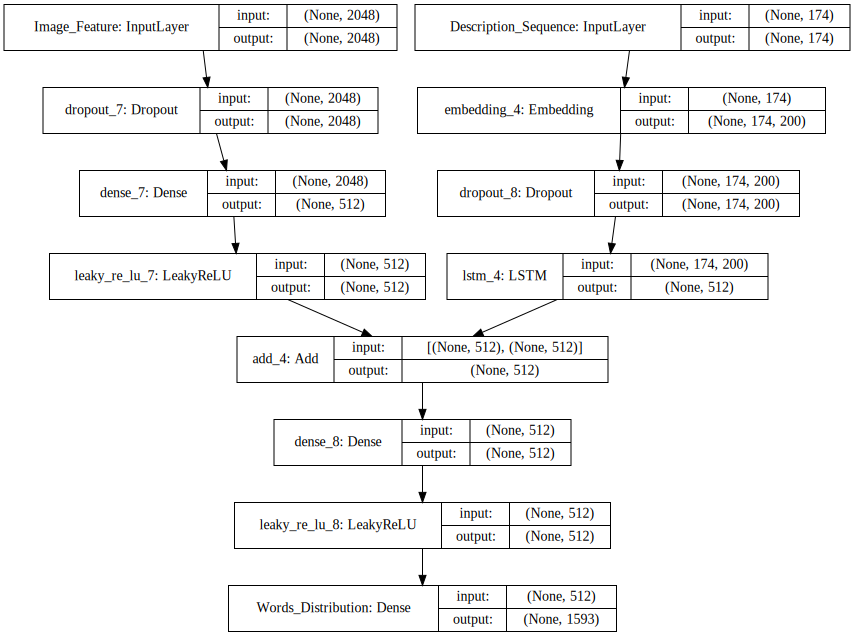

In [49]:
model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=lr))
model.show()

In [50]:
# model.load('weights/weights__epoch_07__loss_3.3835__rmse_0.0229.h5')

In [ ]:
model.fit(
    train_generator,
    val_generator,
    epochs=epochs,
    steps_per_epoch=len(train_samples)/batch_size,
    callbacks=[
        checkpoint,
        lr_tracker,
        MetricsPlotter(val_generator, plot_interval=30, evaluate_interval=30, batch_size=batch_size)
    ]
)

Epoch 1/6
  1/707 [..............................] - ETA: 11:18 - loss: 5.4706 - rmse: 0.0247

Learning rate (4): 0.001000000047497 (=)


Evaluate model (Each 30 steps):
369/369 [==============================] - 3s 8ms/step

Continue model train:
 14/707 [..............................] - ETA: 8:06 - loss: 5.3323 - rmse: 0.0246

In [ ]:
search = GreedySearch(model, word_to_index, index_to_word, '$', '#', dataset.max_desc_len())

image_path = test_samples[0][0]

show_sample(
    image_path,
    description=search.perform( image_features[image_path])
)